**LAB_10 - Fine-Tune VGG16 for Bird Classification**<br>
**Name:** Hari Prasath Jaikrishnan<br>
**StudenID:** 8901541

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import os
import shutil
from collections import Counter

In [18]:
# Obtain the Data
data_dir = '../../../CSCN8010-lab-submissions/data/lab10/'
train_dir = os.path.join(data_dir, 'train')

# Identify Top 3 Classes
def count_images_per_class(directory):
    class_counts = Counter()
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts

class_counts = count_images_per_class(train_dir)
top_3_classes = sorted(class_counts, key=class_counts.get, reverse=True)[:3]

print("Top 3 Classes:", top_3_classes)

Top 3 Classes: ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


In [19]:
# Data Augmentation
batch_size = 32
input_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
# Train, Validation, and Test Data Generators
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

top_3_classes = ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET'] 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=top_3_classes
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=top_3_classes,
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=top_3_classes,
    shuffle=False
)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [21]:
# Fine-Tune VGG16
num_classes = len(train_generator.class_indices)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/10
24/24 [==============================] - 178s 8s/step - loss: 0.7536 - accuracy: 0.7366 - val_loss: 0.2974 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 195s 8s/step - loss: 0.3785 - accuracy: 0.8925 - val_loss: 0.0948 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 192s 8s/step - loss: 0.2850 - accuracy: 0.9113 - val_loss: 0.0638 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 192s 8s/step - loss: 0.2593 - accuracy: 0.9099 - val_loss: 0.0741 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 169s 7s/step - loss: 0.1901 - accuracy: 0.9395 - val_loss: 0.0282 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 154s 6s/step - loss: 0.1794 - accuracy: 0.9395 - val_loss: 0.0474 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 151s 6s/step - loss: 0.1473 - accuracy: 0.9462 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 8/10
24

In [22]:
#  Model Performance Evaluation
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

accuracy = np.mean(y_pred == y_true)
confusion = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=top_3_classes)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", report)

1/1 [==============================] - 3s 3s/step
Accuracy: 1.0
Confusion Matrix:
 [[5 0 0]
 [0 5 0]
 [0 0 5]]
Classification Report:
                   precision    recall  f1-score   support

    RUFOUS TREPE       1.00      1.00      1.00         5
     HOUSE FINCH       1.00      1.00      1.00         5
D-ARNAUDS BARBET       1.00      1.00      1.00         5

        accuracy                           1.00        15
       macro avg       1.00      1.00      1.00        15
    weighted avg       1.00      1.00      1.00        15



In [23]:
# Step 8: Analyze Model Failures
misclassified_indices = np.where(y_pred != y_true)[0]

for idx in misclassified_indices:
    image_path = test_generator.filepaths[idx]
    true_label = top_3_classes[y_true[idx]]
    predicted_label = top_3_classes[y_pred[idx]]

    img = load_img(image_path, target_size=input_size)
    img_array = img_to_array(img)
    plt.imshow(img_array / 255.0)
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()

In [24]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
24/24 [==============================] - 163s 7s/step - loss: 0.1202 - accuracy: 0.9570 - val_loss: 0.0628 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 385s 16s/step - loss: 0.1162 - accuracy: 0.9651 - val_loss: 0.0217 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 169s 7s/step - loss: 0.1433 - accuracy: 0.9516 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 163s 7s/step - loss: 0.1036 - accuracy: 0.9664 - val_loss: 0.0254 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 152s 7s/step - loss: 0.1080 - accuracy: 0.9704 - val_loss: 0.0326 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 150s 6s/step - loss: 0.0958 - accuracy: 0.9691 - val_loss: 0.0435 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 719s 31s/step - loss: 0.0833 - accuracy: 0.9691 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 8/10


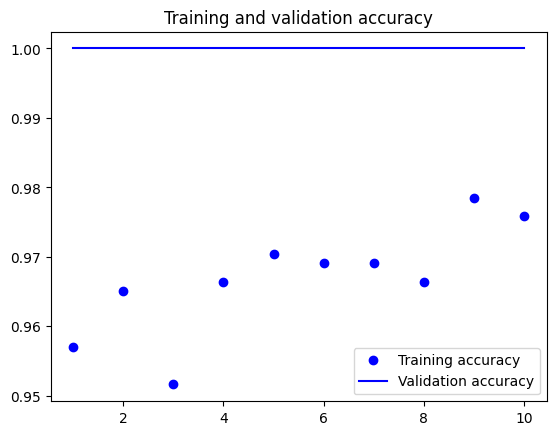

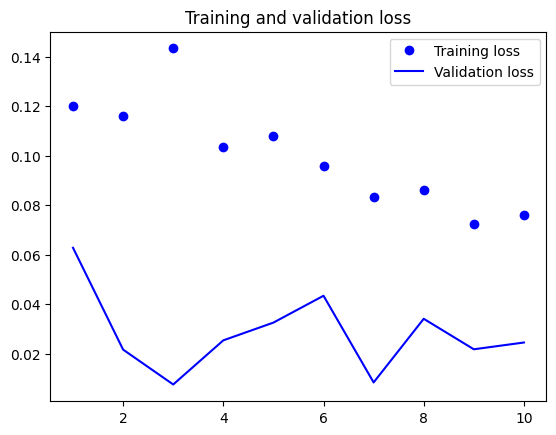

In [25]:
# Accuracy for training and validation
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()